# genetic-nn-tutorial
Basic tutorial for training feed-forward neural networks with genetic algorithms

This code uses a genetic algorithm to train a feed forward neural network to learn to approximate the cosine function.

The only (necessary) dependencies are basic: numpy, random and math.

Note that this is written and published only with education purposes in mind, real-world training of neural networks is generally much more efficient with backpropagation.

Genetic algorithms are worth understanding because, while being time-consuming, they make no requirements for end-to-end differentiability, can handle discrete values (although not done here)  and are easy to code.

In [ ]:
# Note that we only have very basic dependencies
import random
import numpy as np
import math
import matplotlib.pyplot as plt

In [48]:
# Our dataset
dataset = []

# Where to start the X's
x_runner = -1.0
increment = 0.02

# Generate the dataset, we're going to learn the cos(x) function
for i in range(200):
    dataset.append([x_runner, math.cos(x_runner)])
    x_runner += increment

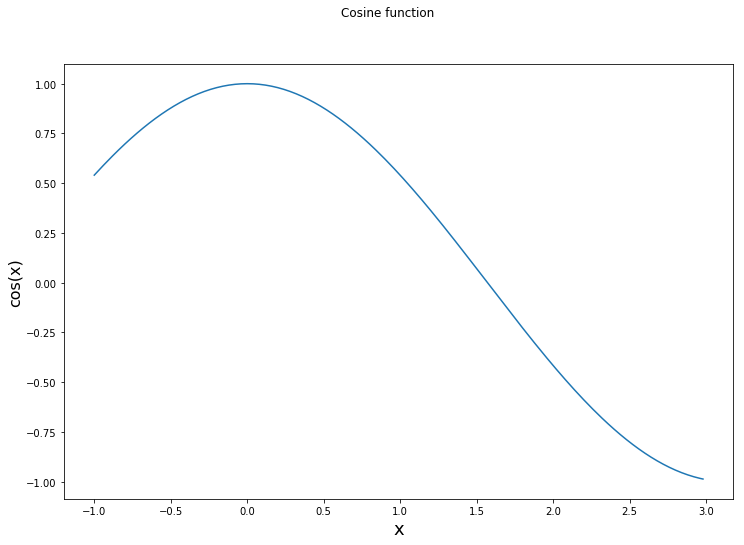

In [49]:
# Plot the whole dataset
fig = plt.figure(figsize=(12, 8))
plt.plot(list(item[0] for item in dataset), list(item[1] for item in dataset))
fig.suptitle('Cosine function')
plt.xlabel('x', fontsize=18)
plt.ylabel('cos(x)', fontsize=16)
plt.show()


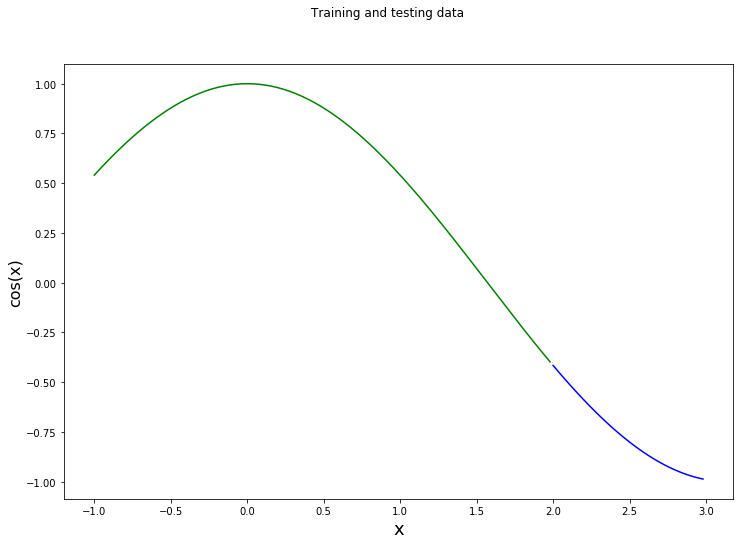

In [50]:
# Split into training and testing sets
training_dataset = dataset[:150]
testing_dataset = dataset[-50:]
# Training inputs
x_training = list(item[0] for item in training_dataset)
# Training outputs
y_training = list(item[1] for item in training_dataset)
# Testing inputs
x_testing = list(item[0] for item in testing_dataset)
# Testing outputs
y_testing = list(item[1] for item in testing_dataset)

# Plot training and testing datasets
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Training and testing data')
plt.plot(x_training, y_training, color='green')
plt.plot(x_testing, y_testing, color='blue')
plt.xlabel('x', fontsize=18)
plt.ylabel('cos(x)', fontsize=16)
plt.show()


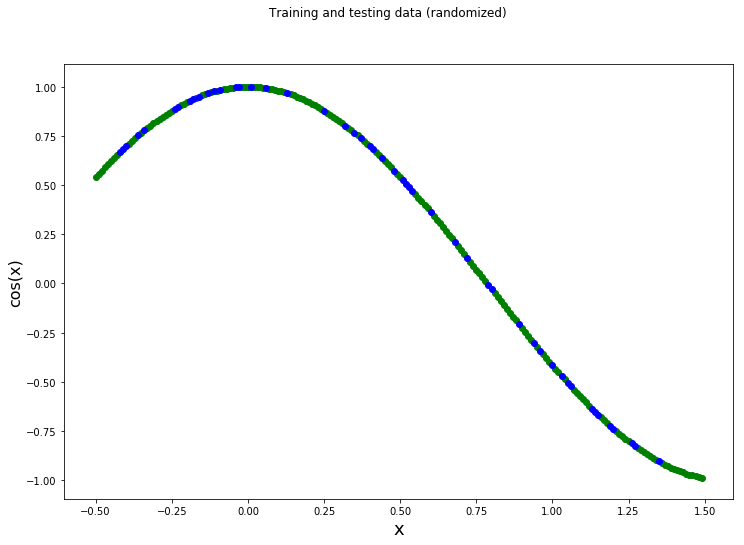

In [51]:
# Shuffle the dataset to make the training and testing sets more evenly distributed
random.shuffle(dataset)

# Redo the split
# Split into training and testing sets
training_dataset = dataset[:150]
testing_dataset = dataset[-50:]
# Training inputs
x_training = list(item[0] for item in training_dataset)
# Training outputs
y_training = list(item[1] for item in training_dataset)
# Testing inputs
x_testing = list(item[0] for item in testing_dataset)
# Testing outputs
y_testing = list(item[1] for item in testing_dataset)

# Normalize X values
for i in range(len(x_training)):
    x_training[i] = x_training[i] / (200*increment - 100*increment)

for i in range(len(x_testing)):
    x_testing[i] = x_testing[i] / (200*increment - 100*increment)


# Plot training and testing datasets
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Training and testing data (randomized)')
plt.scatter(x_training, y_training, color='green')
plt.scatter(x_testing, y_testing, color='blue')
plt.xlabel('x', fontsize=18)
plt.ylabel('cos(x)', fontsize=16)
plt.show()


In [52]:
#Since we're going to be using a genetic algorithm, we need something that will give us a randomly initialized neural network with the structure we want. We will assume one hidden layer.
def produce_neural_network(inputs_size, hidden_layer_size, outputs_size, randomize = True):
    net = {}
    net['inputs_size'] = inputs_size
    net['hidden_size'] = hidden_layer_size
    net['outputs_size'] = outputs_size
    if randomize:
        net['weights_in'] = np.subtract(np.random.rand(inputs_size*hidden_layer_size), 0.5)
        net['weights_out'] = np.subtract(np.random.rand(hidden_layer_size * outputs_size), 0.5)
    net['biases'] = np.subtract(np.random.rand(hidden_layer_size), 0.5)
    return net

In [53]:
# And we need a way to run that neural network on inputs to generate outputs
def run_neural_network(x, net):
    if len(x) <> net['inputs_size']:
        raise Exception('Input dimensions do not match network structure')
    hidden_layer = np.add(np.multiply(x, net['weights_in']), net['biases'])
    # Now for RELU activation
    hidden_layer = hidden_layer * (hidden_layer > 0)
    output_layer = np.matmul( np.matrix([hidden_layer]), np.matrix([net['weights_out']]).T)
    return output_layer

In [54]:
# Genetic algorithm function: As we'll see in a little bit, we need a way to "breed" arrays
def breed_arrays(mother, father, crossover, mutation):
    if len(mother) <> len(father):
        raise Exception('Incompatible parents')
    child = []
    for i in range(len(mother)):
        crossover_decider = random.random()
        childvalue = 0
        if crossover_decider < crossover:
            childvalue = mother[i]
        else:
            childvalue = father[i]
        mutation_decider = random.random()
        if mutation_decider < mutation:
            childvalue += random.random() - 0.5
        child.append(childvalue)
    return child

In [55]:
# Genetic algorithm function: We need to breed neural networks, creating one new network from two parents
def breed_neural_networks(mother_net, father_net, crossover = 0.6, mutation = 0.02 ):
    if mother_net['inputs_size'] <> father_net['inputs_size'] or mother_net['hidden_size'] <> father_net['hidden_size'] or  mother_net['outputs_size'] <> father_net['outputs_size']:
        raise Exception('Incompatible parents')
    child_net = produce_neural_network(mother_net['inputs_size'], mother_net['hidden_size'], mother_net['outputs_size'], randomize=False)
    child_net['biases'] = breed_arrays(mother_net['biases'], father_net['biases'], crossover, mutation)
    child_net['weights_in'] = breed_arrays(mother_net['weights_in'], father_net['weights_in'], crossover, mutation)
    child_net['weights_out'] = breed_arrays(mother_net['weights_out'], father_net['weights_out'], crossover, mutation)
    return child_net

In [56]:
# The final part of the genetic stuff is a fitness function
def evaluate_neural_network(net, input_data, output_data):
    if len(input_data) <> len(output_data):
        raise Exception('Input and output data arrays have different lengths')
    sumSquaredError = 0
    for dataIndex in range(len(input_data)):
        output = run_neural_network([ input_data[dataIndex] ], net)
        sampleError = abs(output - output_data[dataIndex])
        sumSquaredError += sampleError * sampleError
    # We return the sum squared error
    return sumSquaredError

In [57]:
# Need to set some parameters now

# Number of networks in each generation
generation_size = 40
# Size of the hidden layer
hidden_layer_size = 10
# Maximum number of generations to cycle through
generations_max = 200
# Acceptable error threshold
acceptable_error = 0.025


In [58]:
# Let's go ahead and create the first generation
current_generation = []
sorted_by_fitness = []
for i in range(generation_size):
    current_generation.append(produce_neural_network(1, hidden_layer_size, 1))

In [59]:
print 'Starting evolution'

best_score_per_generation = []

# Our main loop that does the evolution
for j in range(generations_max):
    # Evaluate the current generation
    for k in range(generation_size):
        current_generation[k]['sse'] = evaluate_neural_network(current_generation[k], x_training, y_training)
    # Sort by fitness
    sorted_by_fitness = sorted(current_generation, key=lambda k: k['sse'])

    # Print the best one
    print 'Best solution in generation', j, 'has error', sorted_by_fitness[0]['sse'].item(0)
    best_score_per_generation.append(sorted_by_fitness[0]['sse'].item(0))

    # Stop if we're close enough already
    if sorted_by_fitness[0]['sse'] < acceptable_error:
        print 'Done!'
        break

    # Create a new generation and make sure we hang onto the best solution so far
    new_generation = []
    new_generation.append(sorted_by_fitness[0])
    # Do breeding to create the next generation
    for l in range (1, generation_size):
        # Randomly pick mothers and fathers
        mother_index = 0
        father_index = 0
        while mother_index == father_index:
            mother_index = int(round((generation_size-1) * (random.random() * random.random())))
            father_index = int(round((generation_size-1) * random.random()))
        child = breed_neural_networks(sorted_by_fitness[mother_index], sorted_by_fitness[father_index])
        new_generation.append(child)
    current_generation = new_generation
print 'Evolution done'


Starting evolution
Best solution in generation 0 has error 63.5673708176
Best solution in generation 1 has error 59.2066103615
Best solution in generation 2 has error 48.4975308069
Best solution in generation 3 has error 38.2652931374
Best solution in generation 4 has error 38.2652931374
Best solution in generation 5 has error 38.2652931374
Best solution in generation 6 has error 38.2652931374
Best solution in generation 7 has error 29.0557309188
Best solution in generation 8 has error 22.9493575574
Best solution in generation 9 has error 22.9493575574
Best solution in generation 10 has error 18.582765741
Best solution in generation 11 has error 18.582765741
Best solution in generation 12 has error 18.582765741
Best solution in generation 13 has error 15.8486495237
Best solution in generation 14 has error 15.4429122413
Best solution in generation 15 has error 13.9959176081
Best solution in generation 16 has error 13.3978681477
Best solution in generation 17 has error 11.7874767975
Best

Best solution in generation 147 has error 0.257920581711
Best solution in generation 148 has error 0.257920581711
Best solution in generation 149 has error 0.257920581711
Best solution in generation 150 has error 0.257920581711
Best solution in generation 151 has error 0.257920581711
Best solution in generation 152 has error 0.252835566455
Best solution in generation 153 has error 0.252315982807
Best solution in generation 154 has error 0.252315982807
Best solution in generation 155 has error 0.252315982807
Best solution in generation 156 has error 0.252315982807
Best solution in generation 157 has error 0.250555547946
Best solution in generation 158 has error 0.250518418929
Best solution in generation 159 has error 0.242030057861
Best solution in generation 160 has error 0.242030057861
Best solution in generation 161 has error 0.242030057861
Best solution in generation 162 has error 0.242030057861
Best solution in generation 163 has error 0.242030057861
Best solution in generation 164

In [60]:
print 'Starting test phase'

actual_output = []
# Let's test what we learned on the testing data
for i in range(len(x_testing)):
    input_value = x_testing[i]
    desired_output_value = y_testing[i]
    print("input value " + str(input_value) + " output value " + str(desired_output_value))
    result = run_neural_network([input_value], sorted_by_fitness[0])
    actual_output.append(result)
    print 'From X=',input_value,'we wanted',desired_output_value,'and got',actual_output[i].item(0)

Starting test phase
input value -0.41 output value 0.682221207288
From X= -0.41 we wanted 0.682221207288 and got 0.674620413433
input value 0.96 output value -0.342149651151
From X= 0.96 we wanted -0.342149651151 and got -0.314169113005
input value 1.2 output value -0.737393715541
From X= 1.2 we wanted -0.737393715541 and got -0.683382777173
input value 0.41 output value 0.682221207288
From X= 0.41 we wanted 0.682221207288 and got 0.64586190822
input value 1.35 output value -0.904072142017
From X= 1.35 we wanted -0.904072142017 and got -0.903727301935
input value 1.26 output value -0.8129520371
From X= 1.26 we wanted -0.8129520371 and got -0.771520587078
input value 0.53 output value 0.488872081861
From X= 0.53 we wanted 0.488872081861 and got 0.458790067693
input value -0.04 output value 0.996801706303
From X= -0.04 we wanted 0.996801706303 and got 1.04657574075
input value -0.18 output value 0.935896823678
From X= -0.18 we wanted 0.935896823678 and got 0.905835887172
input value 0.54

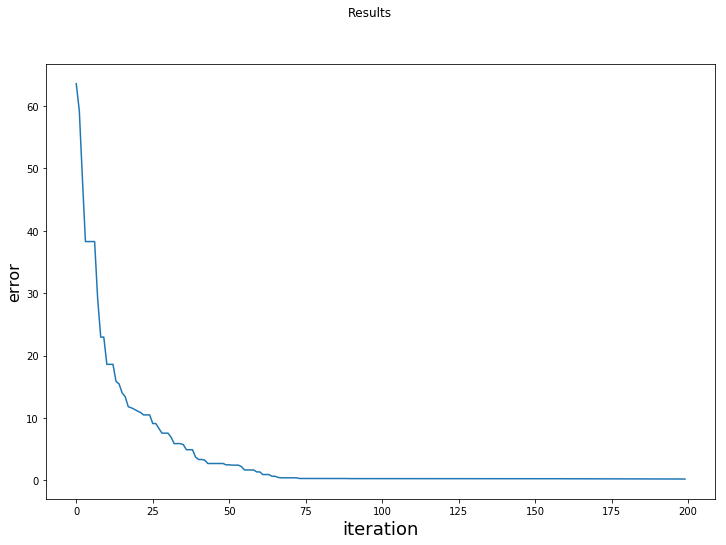

In [61]:
# Plot learning progress
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Results')
plt.plot(best_score_per_generation)
plt.xlabel('iteration', fontsize=18)
plt.ylabel('error', fontsize=16)
plt.show()

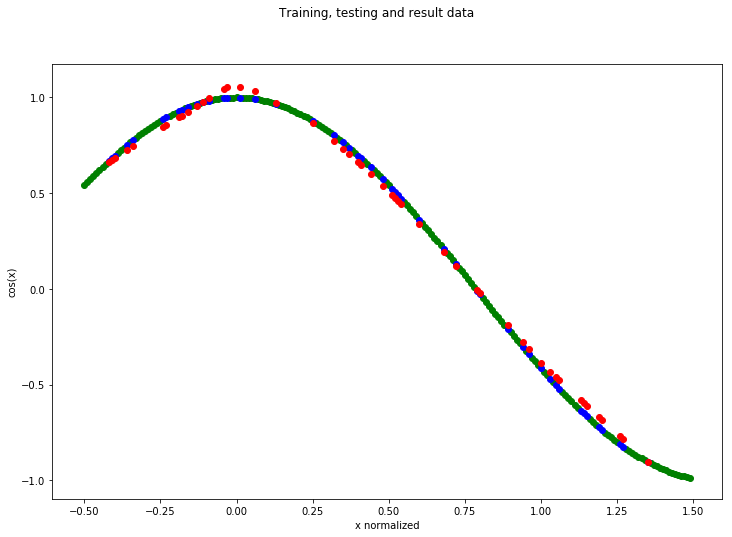

In [62]:
# Plot results vs "ground truth"
fig = plt.figure(figsize=(12, 8))

plt.scatter(x_training, y_training, color='green')
plt.scatter(x_testing, y_testing, color='blue')
plt.scatter(x_testing, actual_output, color='red')
fig.suptitle('Training, testing and result data')
plt.ylabel('cos(x)')
plt.xlabel('x normalized')
plt.show()
